# Chinook Store Business analysis 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


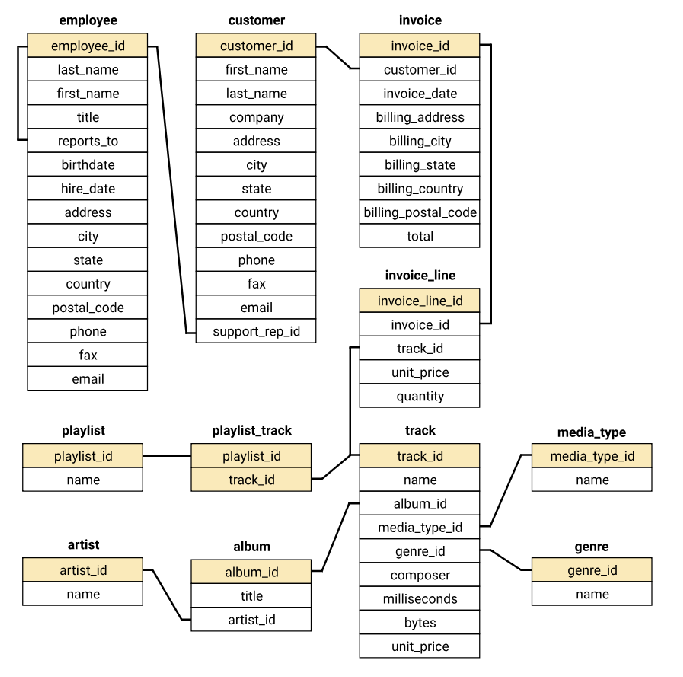

In [2]:
import matplotlib.image as mpimg
plt.figure(figsize=(12,14))
image = mpimg.imread("chnk.png")
plt.imshow(image)
plt.axis('off')
plt.show()

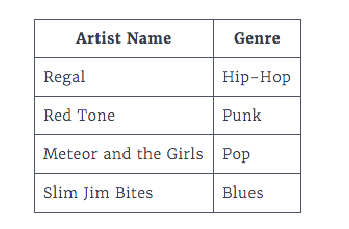

In [3]:
import matplotlib.image as mpimg
plt.figure(figsize=(6,6))
image = mpimg.imread("artists.png")
plt.imshow(image)
plt.axis('off')
plt.show()

## Finding the best Genre fo purchase of the USA stores?

In [4]:

albums = """ 
WITH sold_in_usa AS
    ( 
      SELECT il.invoice_line_id count, il.track_id id FROM customer c
      INNER JOIN invoice i on c.customer_id = i.customer_id
      INNER JOIN invoice_line il on i.invoice_id = il.invoice_id
      WHERE country="USA"
    )

SELECT 
    genre.name Genre, 
    COUNT(usa.count) Sold_Tracks,
    CAST(COUNT(usa.count) AS FLOAT)/
        (SELECT count(1) FROM sold_in_usa) Percentage FROM genre
    INNER JOIN track ON genre.genre_id = track.genre_id
    INNER JOIN sold_in_usa usa ON usa.id = track.track_id
    GROUP BY genre
    ORDER BY 3 DESC

"""

run_query(albums)[:8]

,Genre,Sold_Tracks,Percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932


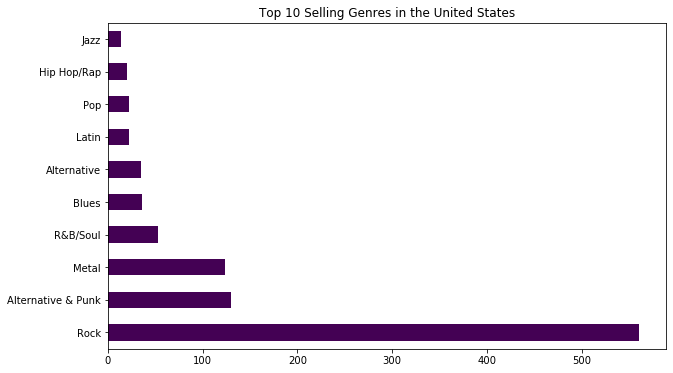

In [5]:
usa_sold_genres = run_query(albums)
usa_sold_genres.set_index("Genre", inplace=True, drop=True)
usa_sold_genres
plt.figure(figsize=(10,6))
usa_sold_genres["Sold_Tracks"][:10].plot.barh(title="Top 10 Selling Genres in the United States", 
                                              align='center',colormap='viridis')

plt.ylabel('')

plt.show()

The results show that Rock music has far more audience than any other genre in the USA. If we had an option to purchase from an artits in that genre, one artist from the rock genre was worth any combination of the other genres.

But, Based on the Genre demands in the USA and if we want to pick three artists from the list to purchase albums from, the following artists  should be selected in order:
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and The Girls (pop)


## Performance Analysis of the Employees

In [6]:
agents = """ 

SELECT  
    e.first_name || " " || e.last_name Employee, e.title, e.country Country,
    strftime('%Y %m',e.hire_date) Year_Month_hired,
    SUM(i.total) Total_Sale FROM employee e
    INNER JOIN customer c ON c.support_rep_id = employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    ORDEr BY Total_Sale DESC

"""

run_query(agents)

,Employee,title,Country,Year_Month_hired,Total_Sale
0,Jane Peacock,Sales Support Agent,Canada,2017 04,1731.51
1,Margaret Park,Sales Support Agent,Canada,2017 05,1584.00
2,Steve Johnson,Sales Support Agent,Canada,2017 10,1393.92


There are three Sales Support Agents that the customers are refered to for Purchase all from Canada. Although Jane Peacok is leading the other two in sales, they have not been hired in the same date.

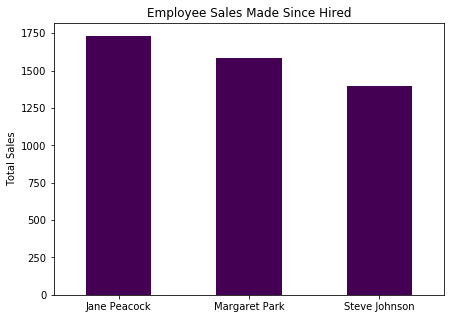

In [7]:
employee_perf = run_query(agents)
employee_perf.set_index("Employee", inplace=True, drop=True)
plt.figure(figsize=(7,5))
employee_perf["Total_Sale"].plot.bar(title="Employee Sales Made Since Hired", align='center',colormap='viridis')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Total Sales')

plt.show()

## Sales Per Country

We look at some statistics per countries below.
To avoid having a long list, we group countries with 1 total of one sale to the "others" group. Also, We sort the data in a way that others is the last in the sorted list by the total price.

In [8]:
countries = """
WITH modified_countries AS
    (
      SELECT 
      CASE 
      WHEN (SELECT COUNT(*) FROM customer
            where country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
      END AS country,
      c.customer_id AS customer,il.* FROM customer c
      INNER JOIN invoice i ON i.customer_id=c.customer_id
      INNER JOIN invoice_line il ON il.invoice_id=i.invoice_id
    )
 


SELECT 
       Country, Total_Customer, Total_Sale, Average_per_customer, Average_Order_Value
FROM (
       SELECT
       country Country, 
       COUNT(DISTINCT customer) Total_Customer,
       SUM(unit_price) Total_Sale,
       SUM(unit_price)/COUNT(DISTINCT customer) Average_per_customer,
       SUM(unit_price)/COUNT(DISTINCT invoice_id) Average_Order_Value,
       CASE
       WHEN country = "Other" THEN 1
            ELSE 0
       END AS sort
       FROM modified_countries
       GROUP BY Country
       ORDER BY sort ASC, Total_Sale DESC
    )
"""

run_query(countries)

,Country,Total_Customer,Total_Sale,Average_per_customer,Average_Order_Value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


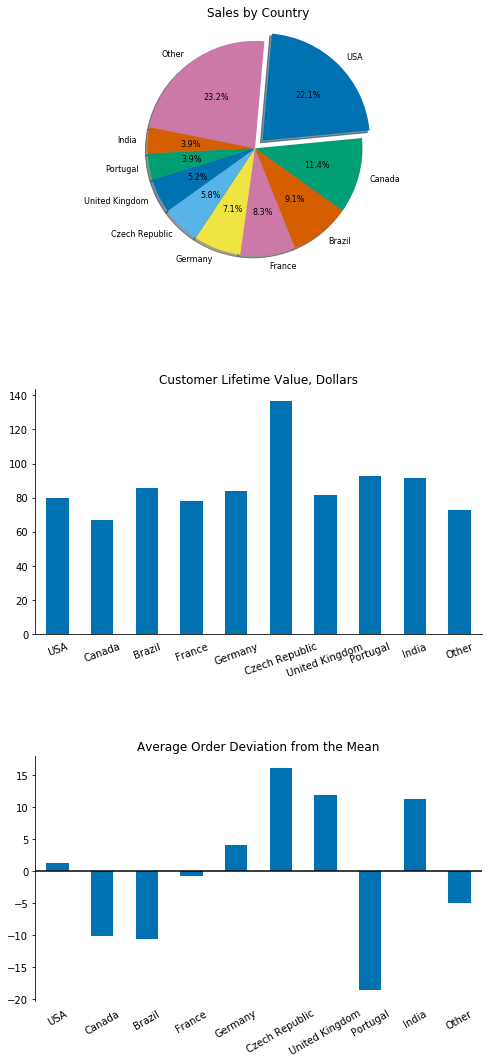

In [14]:
countires_analysis = run_query(countries)
countires_analysis.set_index("Country", drop=True, inplace=True)

fig, axes = plt.subplots(3,1, figsize=(8, 18))
ax1, ax2, ax3 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)
plt.style.use('seaborn-colorblind')

explode=exp=[0]*len(countires_analysis["Total_Sale"])
explode[0]=0.1


countires_analysis["Total_Sale"].plot.pie(ax=ax1,explode=explode, shadow =True,
    startangle=85, counterclock=False, title='Sales by Country', fontsize=8, autopct='%1.1f%%')
ax1.axis('equal') 
ax1.set_ylabel('')

countires_analysis["Average_per_customer"].plot.bar(
    ax=ax2, title="Customer Lifetime Value, Dollars")


ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.xaxis.label.set_visible(False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False,labelrotation=20)


difference_from_avg = countires_analysis['Average_Order_Value'] * 100 / countires_analysis['Average_Order_Value'].mean() - 100
difference_from_avg.plot.bar(ax=ax3, title="Average Order Deviation from the Mean")
ax3.axhline(0,color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.xaxis.label.set_visible(False)
ax3.tick_params(axis='x', which='both', bottom=False, top=False,labelrotation=30)

plt.show()

Based on the deviation of orders plot and with considering the other two plots, it seems that Czech Republic, United Kingdo and India have a good potential to expand the business in. However, based on the pie plot these countries contain a small portion of the data which means we need to start testing this senario for a small group and expand it if it worked.

## Album or Individual track purchase

We want to check if it is a good idea to apply the following strategy:

changing purchasing strategy to save money. The strategy considered is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

In [19]:
album_or_track = """
WITH first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
    
SELECT
    album_purchase,
    COUNT(invoice_id) Invoice_Count,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) Invoice_Percentage
FROM
    (
    SELECT ifs.*,
        CASE
        WHEN
        (SELECT t.track_id FROM track t
         WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                 WHERE t2.track_id = ifs.first_track_id) 
                  EXCEPT 
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id) IS NULL
             AND
                 (SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                  EXCEPT 
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id)) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM first_track ifs)
GROUP BY album_purchase
"""
run_query(album_or_track)

,album_purchase,Invoice_Count,Invoice_Percentage
0,no,500,0.814332
1,yes,114,0.185668


18.5% of the purchases are full albums. This means that around 1/5 of the customers want full albums and with applying the above strategy there is a chance to loose those customers. Another step we can take is to check which genre or artists these full album purchaces are from. If there was a trend there we could start trying to apply this strategy to the less album purchase popular genres.